# Text Mining and Analysis

In [2]:
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn import model_selection, preprocessing, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble

import pandas as pd
import numpy as np

In [5]:
df_news = pd.read_csv("training_news.csv", encoding="latin1")
df_news.head()

,category,headline,first_paragraph
0,polit,Trump's Crackdown On Immigrant Parents Puts Mo...,Last month a Health and Human Services officia...
1,polit,Trump's Son Should Be Concerned': FBI Obtained...,The wiretaps feature conversations between Ale...
2,polit,Edward Snowden: There's No One Trump Loves Mor...,"But don't count on Robert Mueller to nail him,..."
3,polit,Booyah: Obama Photographer Hilariously Trolls ...,Just a peeping minute.
4,polit,Ireland Votes To Repeal Abortion Amendment In ...,Irish women will no longer have to travel to t...


In [6]:
df_news.category.value_counts()

polit       484
health      433
economi     389
crime       385
other       318
educ        313
unemploy    194
corrupt     130
hunger       23
Name: category, dtype: int64

In [7]:
sample_news = df_news["headline"][100]

print(sample_news)
print(gensim.utils.simple_preprocess(sample_news))

EMILYâs List-Backed Lawyer Wins Democratic Primary In Pennsylvania Swing District
['emilyâ', 'list', 'backed', 'lawyer', 'wins', 'democratic', 'primary', 'in', 'pennsylvania', 'swing', 'district']


In [8]:
# English version
stoplist = gensim.parsing.preprocessing.STOPWORDS

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stoplist and len(token) > 3:
            result.append(token) 
    result = " ".join(result)
    return result

In [9]:
print(sample_news)
print(preprocess(sample_news))

EMILYâs List-Backed Lawyer Wins Democratic Primary In Pennsylvania Swing District
emilyâ list backed lawyer wins democratic primary pennsylvania swing district


In [10]:
df_news['clean_text'] = df_news['headline'].map(preprocess)

df_news.sample(5)

,category,headline,first_paragraph,clean_text
2613,polit,The Venezuelan government escaped a condemnati...,NaN,venezuelan government escaped condemnation gen...
118,polit,South Dakota Congressional Candidate Said Terr...,State Sen. Neal Tapio was the state director f...,south dakota congressional candidate said terr...
904,economi,Chamber welcomes Budget measures,"""Following the delivery of the National Budget...",chamber welcomes budget measures
1516,other,Chile Ã¯Â¿Â½Ã¯Â¿Â½ World Ã¯Â¿Â½Ã¯Â¿Â½ Technolo...,NaN,chile world technology education documents mul...
89,polit,Retiring Lawmakers Have Added $32.8 Million To...,"By Frank Bass, MapLight More than five dozen c...",retiring lawmakers added million campaign trea...


In [11]:
# Important Features

# n-gram level tf-idf 
tfidf = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), stop_words=stoplist, min_df=0.00, max_features=5000)
tfidf.fit( df_news["clean_text"] )
x_tfidf = tfidf.transform( df_news["clean_text"] )

# Term-Frequency matrix
features = pd.DataFrame()
features["tokens"] = tfidf.get_feature_names()
features["counts"] = x_tfidf.sum(axis=0).T

features.sort_values("counts", ascending=False)[:10]

,tokens,counts
673,brazil,203
4703,venezuela,198
2753,news,177
1080,colombia,142
4912,world,130
298,argentina,129
944,chile,122
4607,unemployment,119
2972,president,98
2891,peru,92


Parece que debemos quitar mas stopwords...

In [12]:
from nltk.corpus import stopwords

# Bring in the default English NLTK stop words
stoplist = stopwords.words('english')

# Define additional stopwords in a string
additional_stopwords = """
brazil
venezuela
"""

# Split the the additional stopwords string on each word and then add those words to the NLTK stopwords list
stoplist += additional_stopwords.split()
stoplist = set( stoplist ).union(gensim.parsing.preprocessing.STOPWORDS)

In [13]:
df_news['clean_text'] = df_news['headline'].map(preprocess)

df_news.sample(5)

,category,headline,first_paragraph,clean_text
1179,health,Feeling your oats: Whatâs best and healthy,You might have heard about the health benefits...,feeling oats whatâ best healthy
224,health,Even The Young And Invincible Need Health Insu...,All Andrew Blackshear did was breathe. Driving...,young invincible need health insurance
1714,other,"Rodrigo Duterte, Marine Le Pen, Tribune Media:...",NaN,rodrigo duterte marine tribune media monday br...
1646,other,Argentina -Peru: the support in the Malvinas W...,NaN,argentina peru support malvinas betrayal tonig...
1568,crime,Opinion | How to Keep the FARC Guerrillas Out ...,NaN,opinion farc guerrillas fight


In [14]:
# Important Features

# n-gram level tf-idf 
tfidf = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), stop_words=stoplist, min_df=0.00, max_features=5000)
tfidf.fit( df_news["clean_text"] )
x_tfidf = tfidf.transform( df_news["clean_text"] )

# Term-Frequency matrix
features = pd.DataFrame()
features["tokens"] = tfidf.get_feature_names()
features["counts"] = x_tfidf.sum(axis=0).T

features.sort_values("counts", ascending=False)[:10]

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pablo'] not in stop_words.
  sorted(inconsistent))


,tokens,counts
2755,news,177
1078,colombia,142
4912,world,130
297,argentina,129
942,chile,122
4610,unemployment,119
2974,president,98
2893,peru,92
4541,trump,91
1167,country,90


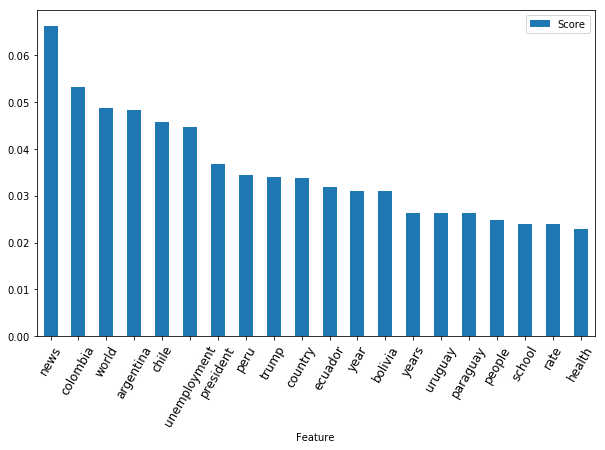

In [15]:
# Creo el dataset features
features = pd.DataFrame()
features["Feature"] = tfidf.get_feature_names()
features["Score"] = x_tfidf.mean(axis=0).T
features.sort_values("Score", ascending=False)[:20].plot(kind="bar", x="Feature", figsize=(10,6))
plt.xticks(fontsize=12, rotation=60)
plt.yticks(fontsize=10)
plt.show()

In [16]:
# split the dataset into training and validation datasets, using label proportions with "stratify"
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_news['clean_text'], df_news['category'], stratify=df_news['category'], test_size=0.3)

In [17]:
# n-gram level tf-idf 
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), stop_words=stoplist, min_df=0.00, max_features=5000)
tfidf.fit( train_x )
train_x_tfidf = tfidf.transform( train_x )
valid_x_tfidf = tfidf.transform( valid_x )

train_x_tfidf.shape

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pablo'] not in stop_words.
  sorted(inconsistent))


(1868, 5000)

In [18]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [19]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), train_x_tfidf, train_y, valid_x_tfidf)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.6604244694132334


In [20]:
# Naive Bayes on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), train_x_tfidf, train_y, valid_x_tfidf)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.6279650436953808


C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
